<a href="https://colab.research.google.com/github/albertoueda/F01/blob/main/2022-04-journal/RQ1d_Contextual_Models_TREC_COVID_229.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RQ1d - Contextual Models TREC-COVID

<div class="alert alert-block alert-info">
<b>Goal:</b> Use contextual models to re-rank the runs.</div>

## Setup

In [ ]:
# COLAB only
!pip install --upgrade git+https://github.com/terrier-org/pyterrier
!pip install --upgrade git+https://github.com/Georgetown-IR-Lab/OpenNIR

from google.colab import drive
drive.mount('/content/drive')

# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/terrier-org/pyterrier to /tmp/pip-req-build-w1nzdcf5
  Running command git clone -q https://github.com/terrier-org/pyterrier /tmp/pip-req-build-w1nzdcf5
  Using cached wget-3.2.zip (10 kB)
  Using cached pyjnius-1.3.0-cp37-cp37m-manylinux2010_x86_64.whl (1.1 MB)
  Using cached matchpy-0.5.5-py3-none-any.whl (69 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
  Using cached chest-0.2.3.tar.gz (9.6 kB)
  Using cached nptyping-1.4.4-py3-none-any.whl (31 kB)
  Using cached ir_datasets-0.5.1-py3-none-any.whl (297 kB)
  Using cached ir_measures-0.3.0.tar.gz (46 kB)
  Using cached typish-1.9.3-py3-none-any.whl (45 kB)
     |████████████████████████████████| 6.4 MB 11.9 MB/s 
     |████████████████████████████████| 72 kB 1.1 MB/s 
     |████████████████████████████████| 294 kB 50.0 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [ ]:
#### Lab
# !export PYTERRIER_HOME="/mnt/hd0/ueda/.pyterrier/"
# index_loc = "/mnt/hd0/ueda/data/trec-covid/index/"
# runs_dir  = 'runs/'

### Note
# !export PYTERRIER_HOME="/home/u/.pyterrier/"
# index_loc = "/home/u/data/pm19/indexes/pm19/"
# runs_dir  = 'runs/'

### Colab
index_loc = "/content/index-trec-covid/"
runs_dir  = '/content/drive/MyDrive/Colab Notebooks/trec-covid/runs/'


In [ ]:
!echo $JAVA_HOME
!echo $PYTERRIER_HOME

import pyterrier as pt, pandas as pd, numpy as np, re, os, sys, warnings
import seaborn as sns, matplotlib.pyplot as plt

if not pt.started(): 
    pt.init(
        boot_packages = ["com.github.terrierteam:terrier-prf:-SNAPSHOT"], 
        tqdm = 'notebook'
    )

os.environ['ONIR_ARGS'] = 'data_dir=/mnt/hd0/ueda/onir/'
os.environ['ONIR_PBAR_COLS'] = '' # no ncols for tqdm
import onir_pt

# sys.path.append('../src')  
# import jobim.utils as utils

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()



terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done
terrier-prf -SNAPSHOT jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [ ]:
dataset = pt.get_dataset("irds:cord19/trec-covid")

# %rm index_loc -rf     #  <------------------

if not os.path.exists(index_loc + '/data.properties'):
    indexer = pt.IterDictIndexer(index_loc)
    indexer.setProperties(**{
        'metaindex.compressed.reverse.allow.duplicates' : 'true',
    })
    indexer.index(dataset.get_corpus_iter(), fields=('title', 'abstract'), meta=('docno',))
    
index_ref = pt.IndexRef.of(index_loc)
# index = pt.IndexFactory.of(index_ref)
index_ref

[INFO] [starting] building docstore
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
docs_iter:   0%|                                    | 0/192509 s<?, ?doc/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 0.00/269M s<?, ?B/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 24.6k/269M s<26:38, 168kB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 57.3k/269M s<23:59, 187kB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 123k/269M s<17:03, 263kB/s] 
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.

cord19/trec-covid documents:   0%|          | 0/192509 s<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  # Remove the CWD from sys.path while we load stuff.


15:22:12.679 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (8is9x9sc) - further warnings are suppressed
15:23:37.207 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 60 empty documents
15:23:37.408 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.collections.FSOrderedMapFile - Key 8lqzfj2e is not unique: 37597,11755 - keeping 37597
15:23:37.439 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.collections.FSOrderedMapFile - Key 9i9cp0ko is not unique: 30148,11764 - keeping 30148
15:23:37.624 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.collections.FSOrderedMapFile - Key nmchd4ib is not unique: 33508,5153 - keeping 33508
15:23:37.636 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.collections.FSOrderedMapFile - Key nnftb092 is not unique: 37803,18418 - keeping 37803
15:23:37.645 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.collections.FSOrderedMapFile - Key n

<org.terrier.querying.IndexRef at 0x7fb55c5d5470 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x5732368 at 0x7fb55e37e7d0>>

In [ ]:
qrels_complete = dataset.get_qrels()
qrels_complete.iteration = qrels_complete.iteration.astype(float)
qrels_round4_cum = qrels_complete[qrels_complete.iteration <= 4].copy()
qrels_round5 = pt.get_dataset('irds:cord19/trec-covid/round5').get_qrels()
qrels_round5_45topics = qrels_round5[qrels_round5.qid.astype(int) <= 45]
qrels_round5_5topics  = qrels_round5[qrels_round5.qid.astype(int) > 45]

eval_metrics = ["ndcg", "map", "P.10", "P.20", "recip_rank", "ndcg_cut.10", 
                "ndcg_cut.100", "ndcg_cut.20", 'num_ret', 'num_rel_ret']
    
topics = pd.concat(objs=[
    dataset.get_topics('title').rename(columns={'query':'title'}),
    dataset.get_topics('description')['query'].rename('description'),
    dataset.get_topics('narrative')['query'].rename('narrative')
],axis = 1)
                   
topics['query'] = topics['title'] + ' ' + topics['description'] + ' ' + topics['narrative']
topics = topics.drop(columns=['title', 'description', 'narrative'])
topics45 = topics[topics.qid.astype(int) <= 45]
topics5  = topics[topics.qid.astype(int) > 45]


In [ ]:
def remove_residuals(df):
    
    # TODO qrels as param
    qrels_complete['iteration'] = qrels_complete['iteration'].astype(float)
    docs_to_remove = qrels_complete[qrels_complete['iteration'] <= 4]

    m = df.merge(docs_to_remove, how='left', on=['qid','docno'])
    m = m[m.label.isnull()]
    m["rank"] = m.groupby("qid")["score"].rank(ascending=False, method="first").astype(int) - 1

    return m


    
def chooseRelevantDocs(topics, qrels=qrels_round4_cum):
    m = topics.merge(qrels, on="qid") 
    m = m[m.label == 2]
    m["index"] = m.index
    # m["myid"] = m.groupby("qid").rank(ascending=True)["index"].astype(int)
    # m = m[m.myid <= docsPerTopic]
    return m

def extractTokens(rf_query):
    s = rf_query
    s = re.sub("applypipeline:off ", "", s)
    s = re.sub("\^[\d\.]+", "", s)
    return s

In [ ]:
# Sanity Check
br = pt.BatchRetrieve(index_loc, num_results=3)
br.transform(topics[:1])

,qid,docid,docno,rank,score,title,description,narrative,query
0,1,174658,tku1dr32,0,13.527099,coronavirus origin,what is the origin of covid 19,seeking range of information about the sars co...,coronavirus origin what is the origin of covid...
1,1,154740,apc0lm5e,1,13.360608,coronavirus origin,what is the origin of covid 19,seeking range of information about the sars co...,coronavirus origin what is the origin of covid...
2,1,118377,dnla56uh,2,13.087478,coronavirus origin,what is the origin of covid 19,seeking range of information about the sars co...,coronavirus origin what is the origin of covid...


## Re-rank with BERT

In [ ]:
# ~1min
fb_terms = 120  #TODO grid search
fb_docs = 1000 
cutoff_1 = 1500
cutoff_2 = 1000

bm25 = pt.BatchRetrieve(index_loc, wmodel="BM25", num_results=cutoff_1)
dfree = pt.BatchRetrieve(index_loc, wmodel="DFRee", num_results=cutoff_1)
dph = pt.BatchRetrieve(index_loc, wmodel="DPH", num_results=cutoff_1)

chooseRelDocs = pt.apply.generic(chooseRelevantDocs)
rewrite_bo1_rf = chooseRelDocs >> pt.rewrite.Bo1QueryExpansion(index_loc, fb_terms=fb_terms, fb_docs=fb_docs)
rewrite_bo1_prf = pt.rewrite.Bo1QueryExpansion(index_loc)
remove_res = pt.apply.generic(remove_residuals)

bm25_bo1_run = pd.concat(
    [ (rewrite_bo1_rf >> bm25 >> remove_res % cutoff_2).transform(topics45),
      (bm25 >> rewrite_bo1_prf >> bm25 >> remove_res % cutoff_2).transform(topics5) ])

dfree_bo1_run = pd.concat(
    [ (rewrite_bo1_rf >> dfree >> remove_res % cutoff_2).transform(topics45),
      (dfree >> rewrite_bo1_prf >> dfree >> remove_res % cutoff_2).transform(topics5) ])

dph_bo1_run = pd.concat(
    [ (rewrite_bo1_rf >> dph >> remove_res % cutoff_2).transform(topics45),
      (dph >> rewrite_bo1_prf >> dph >> remove_res % cutoff_2).transform(topics5) ])

e = pt.Experiment([ bm25_bo1_run, dfree_bo1_run, dph_bo1_run], 
    topics,                                          # <-------------------- ATTENTION!
    qrels_round5, eval_metrics,
    names = ['bm25_bo1', 'dfree_bo1', 'dph_bo1'],
).round(2)

display(e) 
# results2plot(e, ['ndcg_cut.20', 'P.20', 'map', 'ndcg', 'num_rel_ret'], figsize=(16,4), 
#              title='TREC-COVID')

,name,ndcg,map,P.10,P.20,recip_rank,ndcg_cut.10,ndcg_cut.100,ndcg_cut.20,num_ret,num_rel_ret
0,bm25_bo1,0.65,0.36,0.86,0.80,0.94,0.80,0.57,0.75,49435.0,7222.0
1,dfree_bo1,0.63,0.35,0.85,0.79,0.94,0.79,0.56,0.74,49315.0,6995.0
2,dph_bo1,0.64,0.36,0.86,0.80,0.96,0.80,0.57,0.76,49359.0,7135.0


In [ ]:
bm25_bo1_run.head()

,qid,docid,docno,rank,score,query_0,query,label,iteration
0,1,90041,wlmu65vm,0,32.895414,coronavirus origin what is the origin of covid...,applypipeline:off coronaviru^0.451919558 origi...,NaN,NaN
1,1,90042,75dwpw6l,1,32.895414,coronavirus origin what is the origin of covid...,applypipeline:off coronaviru^0.451919558 origi...,NaN,NaN
3,1,149051,siz32uvy,2,32.115296,coronavirus origin what is the origin of covid...,applypipeline:off coronaviru^0.451919558 origi...,NaN,NaN
6,1,118377,dnla56uh,3,31.245799,coronavirus origin what is the origin of covid...,applypipeline:off coronaviru^0.451919558 origi...,NaN,NaN
17,1,64935,v861kk0i,4,28.763928,coronavirus origin what is the origin of covid...,applypipeline:off coronaviru^0.451919558 origi...,NaN,NaN


In [ ]:
rerank_pipeline = (pt.text.get_text(dataset, 'title') 
    >> pt.text.get_text(dataset, 'abstract') 
    >> pt.apply.title_abstract(lambda row: row['title'] + ' ' + row['abstract'])
    >> pt.apply.generic(lambda x: x.rename(columns={'title_abstract': 'text'}))
    >> onir_pt.reranker('vanilla_transformer', 'bert'))

e = pt.Experiment(
    [ bm25_bo1_run, bm25_bo1_run >> rerank_pipeline,
      dfree_bo1_run, dfree_bo1_run >> rerank_pipeline,
      dph_bo1_run, dph_bo1_run >> rerank_pipeline,      
    ], 
    topics[:5],                                          # <-------------------- ATTENTION!
    qrels_round5, eval_metrics,
    names = ['bm25_bo1', 'bm25_bo1 >> bert',
             'dfree_bo1', 'dfree_bo1 >> bert',
             'dph_bo1', 'dph_bo1 >> bert'
             ],
).round(2)

e

[2022-06-02 18:38:47,280][VanillaTransformer][WARNING] It's usually bad to use VanillaBert with non-trainable embeddings. Consider setting `vocab.train=True`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Coercion of a dataframe into a transformer is deprecated; use a pt.Transformer.from_df() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Coercion of a dataframe into a transformer is deprecated; use a pt.Transformer.from_df() instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Coercion of a dataframe into a transformer is deprecated; use a pt.Transformer.from_df() instead
  # Remove the CWD from sys.path while we load stuff.


[2022-06-02 18:38:47,655][onir_pt][DEBUG] using GPU (deterministic)
[2022-06-02 18:38:47,813][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/1250 s<?, ?it/s]

[2022-06-02 18:40:41,358][onir_pt][DEBUG] [finished] batches: [01:54] [1250it] [11.01it/s]
[2022-06-02 18:40:41,772][onir_pt][DEBUG] using GPU (deterministic)
[2022-06-02 18:40:41,779][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/1250 s<?, ?it/s]

[2022-06-02 18:42:38,612][onir_pt][DEBUG] [finished] batches: [01:57] [1250it] [10.70it/s]
[2022-06-02 18:42:39,005][onir_pt][DEBUG] using GPU (deterministic)
[2022-06-02 18:42:39,011][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/1250 s<?, ?it/s]

[2022-06-02 18:44:31,573][onir_pt][DEBUG] [finished] batches: [01:53] [1250it] [11.11it/s]


,name,ndcg,map,P.10,P.20,recip_rank,ndcg_cut.10,ndcg_cut.100,ndcg_cut.20,num_ret,num_rel_ret
0,bm25_bo1,0.64,0.34,0.74,0.77,1.00,0.66,0.47,0.67,4959.0,555.0
1,bm25_bo1 >> bert,0.43,0.07,0.04,0.05,0.15,0.04,0.06,0.04,4959.0,555.0
2,dfree_bo1,0.64,0.34,0.80,0.78,1.00,0.71,0.46,0.66,4953.0,555.0
3,dfree_bo1 >> bert,0.43,0.08,0.06,0.04,0.10,0.02,0.06,0.02,4953.0,555.0
4,dph_bo1,0.65,0.35,0.84,0.76,1.00,0.70,0.48,0.66,4952.0,561.0
5,dph_bo1 >> bert,0.44,0.08,0.10,0.07,0.21,0.08,0.07,0.06,4952.0,561.0


## Re-rank with other SciBERT and others

In [93]:
bert = onir_pt.reranker('vanilla_transformer', 'bert') 
scibert = onir_pt.reranker('vanilla_transformer', 'bert', vocab_config={'bert_base': 'scibert-scivocab-uncased'}) 
sledge = onir_pt.reranker.from_checkpoint('https://macavaney.us/scibert-medmarco.tar.gz', expected_md5="854966d0b61543ffffa44cea627ab63b")

# biobert = onir_pt.reranker('vanilla_transformer', 'bert', vocab_config={'bert_base': 'biobert-pubmed-pmc'}) 
# https://github.com/naver/biobert-pretrained/releases/download/v1.0-pubmed-pmc/biobert_pubmed_pmc.tar.gz

# scibert, my_scibert, biobert, sledge
onir_pt.onir.interfaces.bert_models.MODEL_MAP

extracting: 29.0B [06:24, 13.2s/B]

[2022-06-02 21:08:14,324][VanillaTransformer][WARNING] It's usually bad to use VanillaBert with non-trainable embeddings. Consider setting `vocab.train=True`


extracting: 29.0B [06:31, 13.5s/B]

[2022-06-02 21:08:20,855][VanillaTransformer][WARNING] It's usually bad to use VanillaBert with non-trainable embeddings. Consider setting `vocab.train=True`


{'bert-base-cased': <function onir.interfaces.bert_models._hugging_handler>,
 'bert-base-chinese': <function onir.interfaces.bert_models._hugging_handler>,
 'bert-base-multilingual-cased': <function onir.interfaces.bert_models._hugging_handler>,
 'bert-base-multilingual-uncased': <function onir.interfaces.bert_models._hugging_handler>,
 'bert-base-uncased': <function onir.interfaces.bert_models._hugging_handler>,
 'bert-large-cased': <function onir.interfaces.bert_models._hugging_handler>,
 'bert-large-uncased': <function onir.interfaces.bert_models._hugging_handler>,
 'biobert-pmc': <function onir.interfaces.bert_models._biobert_handler.<locals>.wrapped>,
 'biobert-pubmed': <function onir.interfaces.bert_models._biobert_handler.<locals>.wrapped>,
 'biobert-pubmed-pmc': <function onir.interfaces.bert_models._biobert_handler.<locals>.wrapped>,
 'scibert-basevocab-cased': <function onir.interfaces.bert_models._scibert_handler.<locals>.wrapped>,
 'scibert-basevocab-uncased': <function oni

In [162]:
runs_dir

'/content/drive/MyDrive/Colab Notebooks/trec-covid/runs/'

In [179]:
# "qid", "iter", "docno", "rank", "score", "name"
bm25_bo1_run[['qid', 'iteration', 'docno', 'rank', 'score', 'label']].to_csv(runs_dir + 'bm25_bo1.res.gz', index=False, header=False, sep=' ')
pd.read_csv(runs_dir + 'bm25_bo1.res.gz', header=None, sep=' ')

#TODO

,0,1,2,3,4,5
0,1,NaN,wlmu65vm,0,32.895414,NaN
1,1,NaN,75dwpw6l,1,32.895414,NaN
2,1,NaN,siz32uvy,2,32.115296,NaN
3,1,NaN,dnla56uh,3,31.245799,NaN
4,1,NaN,v861kk0i,4,28.763928,NaN
...,...,...,...,...,...,...
49972,50,NaN,ev1zwrv1,995,10.556499,NaN
49973,50,NaN,2d9tjzn6,996,10.551832,NaN
49974,50,NaN,n8bvxzbb,997,10.550178,NaN
49975,50,NaN,9k2h57q3,998,10.549898,NaN


In [183]:
rerank_setup = (pt.text.get_text(dataset, 'title') 
    >> pt.text.get_text(dataset, 'abstract') 
    >> pt.apply.title_abstract(lambda row: row['title'] + ' ' + row['abstract'])
    >> pt.apply.generic(lambda x: x.rename(columns={'title_abstract': 'text'}))
)
    
bm25_bo1_then_scibert = bm25_bo1_run >> rerank_setup >> scibert
bm25_bo1_then_sledge = bm25_bo1_run >> rerank_setup >> sledge
bm25_bo1_then_bert = bm25_bo1_run >> rerank_setup >> bert

e = pt.Experiment(
    [bm25_bo1_run, 
     bm25_bo1_then_scibert, bm25_bo1_then_sledge, #bm25_bo1_then_bert, 
    #  dfree_bo1_run >> rerank_setup >> onir_pt.reranker('vanilla_transformer', 'bert'),
    #  dph_bo1_run >> rerank_setup >> onir_pt.reranker('vanilla_transformer', 'bert'),      
    ], 
    topics,                                          # <-------------------- ATTENTION!
    qrels_round5, eval_metrics,
    names = ['bm25_bo1', 'bm25_bo1_then_scibert', 'bm25_bo1_then_sledge', #'bm25_bo1_then_bert',
            #  'dfree_bo1 >> bert',
            #  'dph_bo1 >> bert'
             ],
    save_dir = runs_dir, save_mode = 'overwrite'
).round(2)

e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Coercion of a dataframe into a transformer is deprecated; use a pt.Transformer.from_df() instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Coercion of a dataframe into a transformer is deprecated; use a pt.Transformer.from_df() instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Coercion of a dataframe into a transformer is deprecated; use a pt.Transformer.from_df() instead
  if __name__ == '__main__':
extracting: 29.0B [1:50:19, 228s/B]

[2022-06-02 22:52:08,856][onir_pt][DEBUG] using GPU (deterministic)
[2022-06-02 22:52:08,877][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/12495 s<?, ?it/s]

extracting: 29.0B [1:50:19, 228s/B]


[2022-06-02 23:09:28,752][onir_pt][DEBUG] [finished] batches: [17:20] [12495it] [12.02it/s]
[2022-06-02 23:09:31,510][onir_pt][DEBUG] using GPU (deterministic)
[2022-06-02 23:09:31,516][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/12495 s<?, ?it/s]

[2022-06-02 23:27:51,220][onir_pt][DEBUG] [finished] batches: [18:20] [12495it] [11.36it/s]


,name,ndcg,map,P.10,P.20,recip_rank,ndcg_cut.10,ndcg_cut.100,ndcg_cut.20,num_ret,num_rel_ret
0,bm25_bo1,0.65,0.36,0.86,0.80,0.94,0.80,0.57,0.75,49435.0,7222.0
1,bm25_bo1_then_scibert,0.49,0.13,0.24,0.21,0.53,0.23,0.19,0.20,49435.0,7222.0
2,bm25_bo1_then_sledge,0.51,0.16,0.32,0.28,0.55,0.30,0.24,0.27,49435.0,7222.0


## Linear combinations

In [180]:
run1 = pt.io.read_results(runs_dir + 'bm25_bo1.res.gz') 
run1

,qid,docno,rank,score,name
0,1,0,32,NaN,NaN
1,1,1,32,NaN,NaN
2,1,2,32,NaN,NaN
3,1,3,31,NaN,NaN
4,1,4,28,NaN,NaN
...,...,...,...,...,...
49972,50,995,10,NaN,NaN
49973,50,996,10,NaN,NaN
49974,50,997,10,NaN,NaN
49975,50,998,10,NaN,NaN


In [223]:
runs_dir+'lc_bm25_scibert-bw0.1.res.gz'

'/content/drive/MyDrive/Colab Notebooks/trec-covid/runs/lc_bm25_scibert-bw0.1.res.gz'

In [224]:
# norm = pt.pipelines.PerQueryMaxMinScoreTransformer()
run1 = pt.io.read_results(runs_dir + 'bm25_bo1-t50.res.gz')  #TODO: bm25_bo1 
run2 = pt.model.add_ranks( pt.io.read_results(runs_dir + 'bm25_bo1_then_scibert.res.gz') ).sort_values(["qid", "rank"], ascending=[True,True])

from sklearn.preprocessing import minmax_scale
run1["score"] = run1.groupby('qid')["score"].transform(lambda x: minmax_scale(x))
run2["score"] = run2.groupby('qid')["score"].transform(lambda x: minmax_scale(x))

bert_weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
combs = [None] * len(bert_weights)
lc = run1.merge(run2, on=["qid", "docno"], suffixes=[None, "_r"], how='outer')
lc["score"] = lc["score"].fillna(0)
lc["score_r"] = lc["score_r"].fillna(0)

for bw in bert_weights:
    new_lc = lc.copy()
    new_lc["score"] = (1-bw) * lc["score"] + bw * lc["score_r"]
    new_lc = pt.model.add_ranks(new_lc).sort_values(["qid", "rank"], ascending=[True,True])
    pt.io.write_results(new_lc, runs_dir+'lc_bm25_scibert-bw'+str(bw)+'.res')
    combs[ int(bw*10) ] = new_lc

e = pt.Experiment(
    combs, 
    topics,                                          # <-------------------- ATTENTION!
    qrels_round5, eval_metrics,
    names = ['lc_bm25_scibert-bw' + str(bw) for bw in bert_weights],
).round(2)

e

,name,ndcg,map,P.10,P.20,recip_rank,ndcg_cut.10,ndcg_cut.100,ndcg_cut.20,num_ret,num_rel_ret
0,lc_bm25_scibert-bw0.0,0.65,0.36,0.86,0.80,0.94,0.80,0.57,0.75,49435.0,7222.0
1,lc_bm25_scibert-bw0.1,0.65,0.36,0.86,0.80,0.96,0.81,0.57,0.76,49435.0,7222.0
2,lc_bm25_scibert-bw0.2,0.65,0.37,0.85,0.80,0.96,0.80,0.57,0.76,49435.0,7222.0
3,lc_bm25_scibert-bw0.3,0.65,0.36,0.86,0.78,0.97,0.81,0.56,0.75,49435.0,7222.0
4,lc_bm25_scibert-bw0.4,0.64,0.34,0.84,0.75,0.98,0.79,0.55,0.73,49435.0,7222.0
5,lc_bm25_scibert-bw0.5,0.63,0.31,0.78,0.70,0.99,0.75,0.51,0.69,49435.0,7222.0
6,lc_bm25_scibert-bw0.6,0.60,0.27,0.69,0.61,0.89,0.65,0.45,0.59,49435.0,7222.0
7,lc_bm25_scibert-bw0.7,0.57,0.22,0.54,0.48,0.83,0.51,0.37,0.47,49435.0,7222.0
8,lc_bm25_scibert-bw0.8,0.53,0.18,0.38,0.36,0.64,0.35,0.29,0.33,49435.0,7222.0
9,lc_bm25_scibert-bw0.9,0.50,0.15,0.27,0.27,0.57,0.26,0.23,0.25,49435.0,7222.0


In [225]:
run1 = pt.io.read_results(runs_dir + 'bm25_bo1-t50.res.gz') 
run2 = pt.model.add_ranks( pt.io.read_results(runs_dir + 'bm25_bo1_then_sledge.res.gz') ).sort_values(["qid", "rank"], ascending=[True,True])

from sklearn.preprocessing import minmax_scale
run1["score"] = run1.groupby('qid')["score"].transform(lambda x: minmax_scale(x))
run2["score"] = run2.groupby('qid')["score"].transform(lambda x: minmax_scale(x))

bert_weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
combs = [None] * len(bert_weights)
lc = run1.merge(run2, on=["qid", "docno"], suffixes=[None, "_r"], how='outer')
lc["score"] = lc["score"].fillna(0)
lc["score_r"] = lc["score_r"].fillna(0)

for bw in bert_weights:
    new_lc = lc.copy()
    new_lc["score"] = (1-bw) * lc["score"] + bw * lc["score_r"]
    new_lc = pt.model.add_ranks(new_lc).sort_values(["qid", "rank"], ascending=[True,True])
    pt.io.write_results(new_lc, runs_dir+'lc_bm25_sledge-bw'+str(bw)+'.res')
    combs[ int(bw*10) ] = new_lc

e2 = pt.Experiment(
    combs, 
    topics,                                          # <-------------------- ATTENTION!
    qrels_round5, eval_metrics,
    names = ['lc_bm25_sledge-bw' + str(bw) for bw in bert_weights],
).round(2)

e2

,name,ndcg,map,P.10,P.20,recip_rank,ndcg_cut.10,ndcg_cut.100,ndcg_cut.20,num_ret,num_rel_ret
0,lc_bm25_sledge-bw0.0,0.65,0.36,0.86,0.80,0.94,0.80,0.57,0.75,49435.0,7222.0
1,lc_bm25_sledge-bw0.1,0.66,0.37,0.86,0.80,0.96,0.81,0.58,0.76,49435.0,7222.0
2,lc_bm25_sledge-bw0.2,0.66,0.37,0.86,0.80,0.97,0.81,0.58,0.77,49435.0,7222.0
3,lc_bm25_sledge-bw0.3,0.65,0.37,0.85,0.78,0.97,0.81,0.57,0.75,49435.0,7222.0
4,lc_bm25_sledge-bw0.4,0.65,0.35,0.82,0.76,0.98,0.79,0.56,0.73,49435.0,7222.0
5,lc_bm25_sledge-bw0.5,0.64,0.33,0.79,0.70,0.97,0.76,0.53,0.69,49435.0,7222.0
6,lc_bm25_sledge-bw0.6,0.61,0.29,0.69,0.62,0.90,0.67,0.47,0.61,49435.0,7222.0
7,lc_bm25_sledge-bw0.7,0.58,0.25,0.57,0.51,0.78,0.54,0.40,0.50,49435.0,7222.0
8,lc_bm25_sledge-bw0.8,0.55,0.21,0.45,0.42,0.69,0.43,0.33,0.40,49435.0,7222.0
9,lc_bm25_sledge-bw0.9,0.53,0.18,0.37,0.34,0.64,0.36,0.28,0.33,49435.0,7222.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


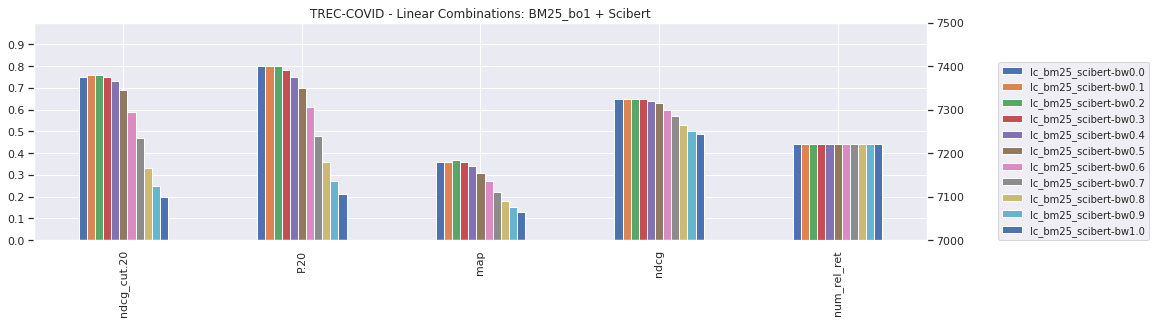

In [217]:


results2plot(e, ['ndcg_cut.20', 'P.20', 'map', 'ndcg', 'num_rel_ret'], 
             ylim_a=7000, ylim_b=7500, figsize=(16,4), title='TREC-COVID - Linear Combinations: BM25_bo1 + Scibert')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


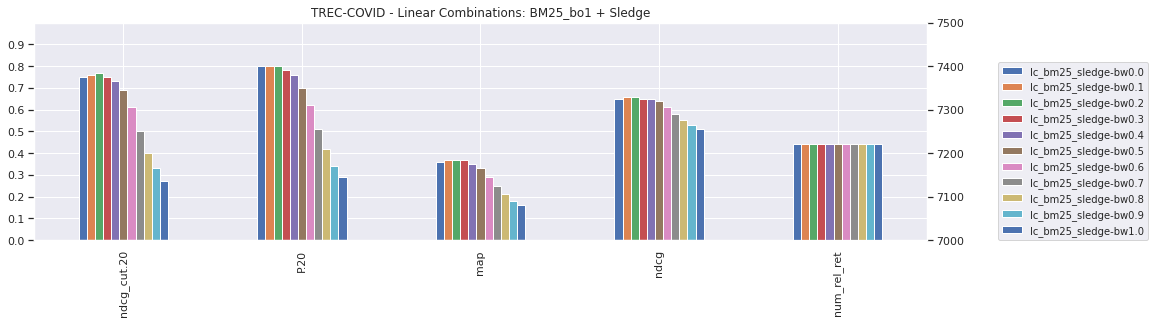

In [212]:
results2plot(e2, ['ndcg_cut.20', 'P.20', 'map', 'ndcg', 'num_rel_ret'], 
             ylim_a=7000, ylim_b=7500, figsize=(16,4), title='TREC-COVID - Linear Combinations: BM25_bo1 + Sledge')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


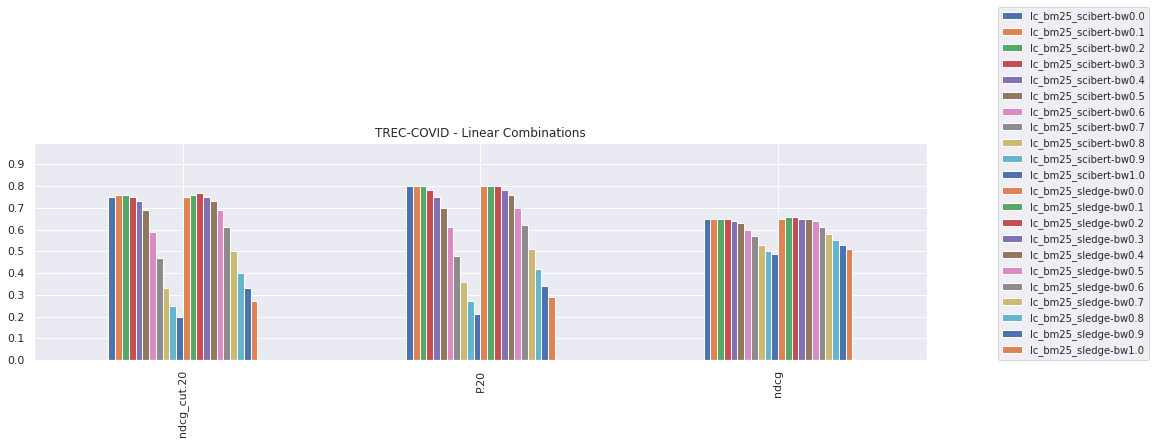

In [218]:
results2plot(pd.concat([e, e2]), 
             ['ndcg_cut.20', 'P.20', 'ndcg'], 
             ylim_a=7000, ylim_b=7500, figsize=(16,4), title='TREC-COVID - Linear Combinations')

,name,ndcg,map,P.10,P.20,recip_rank,ndcg_cut.10,ndcg_cut.100,ndcg_cut.20,num_ret,num_rel_ret
0,bm25_bo1,0.65,0.36,0.86,0.80,0.94,0.80,0.57,0.75,49435.0,7222.0
1,bm25 >> scibert,0.49,0.13,0.24,0.21,0.53,0.23,0.19,0.20,49435.0,7222.0
2,bm25 >> sledge,0.51,0.16,0.32,0.29,0.55,0.30,0.24,0.27,49435.0,7222.0
3,bm25 + sledge,0.66,0.37,0.86,0.80,0.97,0.81,0.58,0.77,49435.0,7222.0
4,covidex.r5.d2q.2s-BEST-AUTOMATIC,0.59,0.32,0.87,0.77,0.96,0.82,0.55,0.75,49916.0,6461.0
5,covidex.r5.2s.lr-2ND-BEST-FEEDBACK,0.63,0.39,0.92,0.85,0.99,0.89,0.63,0.83,49900.0,6722.0
6,UPrrf93-wt-r5-BEST-FEEDBACK,0.74,0.47,0.95,0.88,1.00,0.91,0.68,0.85,49887.0,8085.0


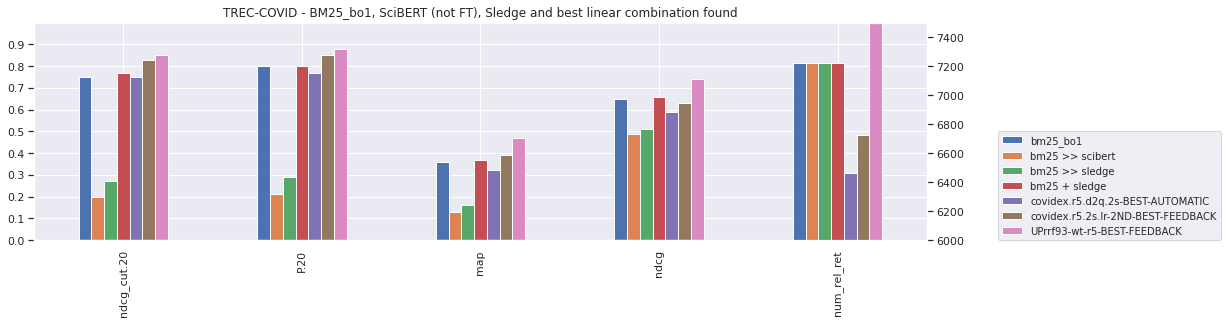

In [236]:
def results2plot(results, eval_metrics=None, models=None, figsize=(8,3), title=None, ylim_a=None, ylim_b=None):
    
    # converts df to a better format
    if eval_metrics: r = results[['name'] + eval_metrics].T
    else: r = results.T
            
    new_header = r.iloc[0]
    r = r[1:]
    r.columns = new_header
    r = r.astype(float).round(3)    
    if models: r = r[models]        
   
    # plot
    fig, ax = plt.subplots()
    r.drop('num_rel_ret', errors='ignore').plot.bar(ax=ax, figsize=figsize, yticks=np.arange(0.0, 1, 0.1), title=title)
    ax.set_ylim(0,1)
    plt.legend(loc=(1.08, 0), prop={'size': 10})
    
    if 'num_rel_ret' in eval_metrics:
        ax2 = ax.twinx()
        if ylim_a: ax2.set_ylim(ylim_a, ylim_b)
        r.plot.bar(ax=ax2, secondary_y=['num_rel_ret'], legend=False) 
    
    plt.close()
    return fig


# 'UPrrf93-wt-r5-BEST-FEEDBACK', 'covidex.r5.2s.lr-2ND-BEST-FEEDBACK', 'covidex.r5.d2q.2s-BEST-AUTOMATIC', 
# 'uogTrDPH_QE_RF_SB_CB-BEST-OURS', 'uogTrDPH_QE_RF'

e = pt.Experiment(
    [pt.io.read_results(runs_dir + 'bm25_bo1-t50.res.gz'),
     pt.io.read_results(runs_dir + 'lc_bm25_scibert-bw1.0.res'),
     pt.io.read_results(runs_dir + 'lc_bm25_sledge-bw1.0.res'),
     pt.io.read_results(runs_dir + 'lc_bm25_sledge-bw0.2.res'),
     pt.io.read_results(runs_dir + 'covidex.r5.d2q.2s-BEST-AUTOMATIC.res.gz'),
     pt.io.read_results(runs_dir + 'covidex.r5.2s.lr-2ND-BEST-FEEDBACK.res.gz'),
     pt.io.read_results(runs_dir + 'UPrrf93-wt-r5-BEST-FEEDBACK.res.gz'),
     ],
    topics,                                          # <-------------------- ATTENTION!
    qrels_round5, eval_metrics,
    names = ['bm25_bo1', 'bm25 >> scibert', 'bm25 >> sledge', 'bm25 + sledge', 
            'covidex.r5.d2q.2s-BEST-AUTOMATIC',  'covidex.r5.2s.lr-2ND-BEST-FEEDBACK', 'UPrrf93-wt-r5-BEST-FEEDBACK'],
).round(2)

display(e)
results2plot(e, ['ndcg_cut.20', 'P.20', 'map', 'ndcg', 'num_rel_ret'], 
             ylim_a=6000, ylim_b=7500, figsize=(16,4), 
             title='TREC-COVID - BM25_bo1, SciBERT (not FT), Sledge and best linear combination found')

In [230]:
plt.close('all')

In [186]:

while True: pass


KeyboardInterrupt: ignored

## Q&A

In [120]:
# minmax scale looks wrong, see rank=4 score. Why?
norm = pt.pipelines.PerQueryMaxMinScoreTransformer()
(pt.io.read_results(runs_dir + 'bm25_bo1_then_scibert.res.gz') >> norm).transform(topics[:1])

# problem is in the original run rank (sciberto run)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Coercion of a dataframe into a transformer is deprecated; use a pt.Transformer.from_df() instead
  This is separate from the ipykernel package so we can avoid doing imports until


,qid,query,docno,rank,score,name
0,1,coronavirus origin what is the origin of covid...,wlmu65vm,0,0.465321,pyterrier
1,1,coronavirus origin what is the origin of covid...,75dwpw6l,1,0.465321,pyterrier
2,1,coronavirus origin what is the origin of covid...,siz32uvy,2,0.448679,pyterrier
3,1,coronavirus origin what is the origin of covid...,dnla56uh,3,0.339323,pyterrier
4,1,coronavirus origin what is the origin of covid...,v861kk0i,4,0.512313,pyterrier
...,...,...,...,...,...,...
995,1,coronavirus origin what is the origin of covid...,0a5fccio,995,0.387817,pyterrier
996,1,coronavirus origin what is the origin of covid...,mcy43i6a,996,0.332402,pyterrier
997,1,coronavirus origin what is the origin of covid...,4z6wcmxq,997,0.445360,pyterrier
998,1,coronavirus origin what is the origin of covid...,o14m6ldo,998,0.438713,pyterrier


<div class="alert alert-block alert-warning">
<b>Question:</b> Why default br has different scores than before?</div>

In [ ]:
pt.Experiment(
    [pt.BatchRetrieve(index_loc, num_results=1000),
     pt.BatchRetrieve(index_loc, wmodel="BM25"),
     pt.BatchRetrieve(index_loc, wmodel="DFRee"),
     pt.BatchRetrieve(index_loc, wmodel="DPH")],
    topics,
    qrels_round5,
    eval_metrics,
    names=['br', 'bm25', 'dfree', 'dph'],
)

,name,ndcg,map,P.10,P.20,recip_rank,ndcg_cut.10,ndcg_cut.100,ndcg_cut.20,num_ret,num_rel_ret
0,br,0.417826,0.133283,0.336,0.327,0.481650,0.302396,0.265372,0.297594,49217.0,5677.0
1,bm25,0.431036,0.136737,0.312,0.306,0.528574,0.291408,0.262882,0.285969,49373.0,5843.0
2,dfree,0.409267,0.129729,0.340,0.322,0.493943,0.304887,0.268159,0.293551,49178.0,5560.0
3,dph,0.417826,0.133283,0.336,0.327,0.481650,0.302396,0.265372,0.297594,49217.0,5677.0


<div class="alert alert-block alert-success">
<b>Answer:</b> We need to use residual evaluation for round 5.</div>

<div class="alert alert-block alert-warning">
<b>Question:</b> Why qid=8 raises an error?</div>

```python
/usr/local/lib/python3.7/dist-packages/onir/util/__init__.py in subbatch(toks, maxlen)
    248                 nulls = torch.zeros_like(toks[:, :S - stack[-1].shape[1]])
    249                 stack[-1] = torch.cat([stack[-1], nulls], dim=1)
--> 250         return torch.cat(stack, dim=0), SUBBATCH
    251 
NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors) (...)
```

In [ ]:
topics[7:8]

,qid,title,description,narrative,query
7,8,coronavirus under reporting,how has lack of testing availability led to un...,looking for studies answering questions of imp...,coronavirus under reporting how has lack of te...


In [ ]:
br = (pt.BatchRetrieve(index_loc, num_results=1000) 
    >> pt.text.get_text(dataset, 'title') 
    >> pt.text.get_text(dataset, 'abstract') 
    >> pt.apply.title_abstract(lambda row: row['title'] + ' ' + row['abstract'])
)
df = br.transform(topics[7:8])
df[810:820]

,qid,docid,docno,rank,score,query,title,abstract,title_abstract
810,8,107866,4pwgrc5g,810,7.952638,coronavirus under reporting how has lack of te...,Provision of dental services at a single insti...,Coronavirus disease 2019 (COVID-19) has had a ...,Provision of dental services at a single insti...
811,8,169509,7hpvveya,811,7.952638,coronavirus under reporting how has lack of te...,Provision of dental services at a single insti...,Coronavirus disease 2019 (COVID-19) has had a ...,Provision of dental services at a single insti...
812,8,29964,4amnl029,812,7.950176,coronavirus under reporting how has lack of te...,Covid-19: Lack of test and trace data are frus...,,Covid-19: Lack of test and trace data are frus...
813,8,50155,luqlfphw,813,7.950176,coronavirus under reporting how has lack of te...,"Covid-19: Lack of testing in Brazil is a ""majo...",,"Covid-19: Lack of testing in Brazil is a ""majo..."
814,8,91503,zscviypa,814,7.950176,coronavirus under reporting how has lack of te...,Covid-19: Lack of test and trace data are frus...,,Covid-19: Lack of test and trace data are frus...
815,8,113199,rb5o20j2,815,7.950176,coronavirus under reporting how has lack of te...,"Covid-19: Lack of testing in Brazil is a ""majo...",,"Covid-19: Lack of testing in Brazil is a ""majo..."
816,8,164323,52c7myio,816,7.949447,coronavirus under reporting how has lack of te...,An Epidemiological Study on COVID-19: A Rapidl...,Background The outbreak of the novel coronavir...,An Epidemiological Study on COVID-19: A Rapidl...
817,8,106623,qq4r5air,817,7.949423,coronavirus under reporting how has lack of te...,Clinical utility of cardiac troponin measureme...,The novel coronavirus SARS-CoV-2 causes the di...,Clinical utility of cardiac troponin measureme...
818,8,106624,4q5b711h,818,7.949423,coronavirus under reporting how has lack of te...,Clinical utility of cardiac troponin measureme...,The novel coronavirus SARS-CoV-2 causes the di...,Clinical utility of cardiac troponin measureme...
819,8,129684,8vfxwpai,819,7.949283,coronavirus under reporting how has lack of te...,Residual Attention U-Net for Automated Multi-C...,The novel coronavirus disease 2019 (COVID-19) ...,Residual Attention U-Net for Automated Multi-C...


In [ ]:
# isna(), isnull() is not for that ('')
display( df[df.abstract.isna()] ) 
display( df[df.abstract.isnull()] ) 

,qid,docid,docno,rank,score,title,description,narrative,query,abstract


,qid,docid,docno,rank,score,title,description,narrative,query,abstract


In [ ]:
df[df.abstract == '']

,qid,docid,docno,rank,score,query,title,abstract,title_abstract
197,8,42376,17pav1bg,197,9.230177,coronavirus under reporting how has lack of te...,Covid-19: Lack of testing led to patients bein...,,Covid-19: Lack of testing led to patients bein...
198,8,104796,42efk4s5,198,9.230177,coronavirus under reporting how has lack of te...,Covid-19: Lack of testing led to patients bein...,,Covid-19: Lack of testing led to patients bein...
208,8,29139,w0sb4qnl,208,9.178145,coronavirus under reporting how has lack of te...,Covid-19: Lack of capacity led to halting of c...,,Covid-19: Lack of capacity led to halting of c...
209,8,90681,srpgfh3h,209,9.178145,coronavirus under reporting how has lack of te...,Covid-19: Lack of capacity led to halting of c...,,Covid-19: Lack of capacity led to halting of c...
520,8,63700,qtamwrun,520,8.346238,coronavirus under reporting how has lack of te...,Covid-19 and inflammatory bowel disease: quest...,,Covid-19 and inflammatory bowel disease: quest...
521,8,127863,1h41dzp2,521,8.346238,coronavirus under reporting how has lack of te...,COVID-19 and Inflammatory Bowel Disease: Quest...,,COVID-19 and Inflammatory Bowel Disease: Quest...
812,8,29964,4amnl029,812,7.950176,coronavirus under reporting how has lack of te...,Covid-19: Lack of test and trace data are frus...,,Covid-19: Lack of test and trace data are frus...
813,8,50155,luqlfphw,813,7.950176,coronavirus under reporting how has lack of te...,"Covid-19: Lack of testing in Brazil is a ""majo...",,"Covid-19: Lack of testing in Brazil is a ""majo..."
814,8,91503,zscviypa,814,7.950176,coronavirus under reporting how has lack of te...,Covid-19: Lack of test and trace data are frus...,,Covid-19: Lack of test and trace data are frus...
815,8,113199,rb5o20j2,815,7.950176,coronavirus under reporting how has lack of te...,"Covid-19: Lack of testing in Brazil is a ""majo...",,"Covid-19: Lack of testing in Brazil is a ""majo..."


In [ ]:
pipeline = ( pt.BatchRetrieve(index_loc, num_results=1000) 
    >> pt.text.get_text(dataset, 'title') 
    >> pt.text.get_text(dataset, 'abstract') 
    >> pt.apply.title_abstract(lambda row: row['title'] + ' ' + row['abstract'])
    >> pt.apply.generic(lambda x: x.rename(columns={'title_abstract': 'text'}))
    >> reranker
)

pt.Experiment(
    [br, pipeline],
    topics[7:8],
    qrels_round5,
    eval_metrics,
    names=['br', 'br >> rerank'],
)

[2022-06-02 16:17:28,266][onir_pt][DEBUG] using GPU (deterministic)
[2022-06-02 16:17:28,271][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/250 s<?, ?it/s]

[2022-06-02 16:17:49,670][onir_pt][DEBUG] [finished] batches: [21.40s] [250it] [11.68it/s]


,name,ndcg,map,P.10,P.20,recip_rank,ndcg_cut.10,ndcg_cut.100,ndcg_cut.20,num_ret,num_rel_ret
0,br,0.276653,0.046616,0.2,0.35,1.000,0.358954,0.212624,0.36964,979.0,39.0
1,br >> rerank,0.165092,0.009935,0.0,0.00,0.025,0.000000,0.026156,0.00000,979.0,39.0


<div class="alert alert-block alert-success">
<b>Answer: </b>Solved. The problem occured with dos with empty abstracts. Now we include the title to the doc text. An alternative is to discard such docs. </div>

In [ ]:
def read_results_custom(filename, names=["qid", "iter", "docno", "rank", "score", "name"]):
    df = pd.read_csv(filename, sep=r'\s+', names=names)
    df = df.drop(columns="iter")
    df["qid"] = df["qid"].astype(str)
    df["docno"] = df["docno"].astype(str)
    df["rank"] = df["rank"].astype(int)
    df["score"] = df["score"].astype(float)
    return df

# To keep colab alive, at least before captcha
while True: pass

KeyboardInterrupt: ignored

# Next:
 - ~load and run bert models~
 - ~Solve error when running for all topics~
 - ~Include title of articles~
 - BERT | SCIBERT | * | our SCIBERT runs
 - Use linear combinations
 - Use loaded base runs
 - Break abstracts in sections 
 - Rank abstract sections
 - SCIBERT-s runs

# Notes
 - get baselines for TREC-Complete
 - type of publication
 - ndocs to cuttof1
 - progress bar for pt
 - Tuning / Grid Search 
    - https://pyterrier.readthedocs.io/en/latest/tuning.html
 - "*Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex*"
 - trec-covid fulltexts
 - how standard methods (bm25, dph) were using the doc title and abs?

